Step 1: Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

Step 2: Reading data and processing

In [ ]:
# --- 1. DATA PREPARATION ---
df = pd.read_csv("household.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 1.1. Get target time series and resample daily
target_col = 'active_power'
exog_cols = ['temp', 'humidity'] # Important exogenous variables
all_cols = [target_col] + exog_cols

# Resample data to daily average (D)
daily_df = df[all_cols].resample('D').mean().dropna()

# Split training and testing sets (80%)
data = daily_df.values.astype(float)
train_size = int(len(data) * 0.8)
train_df, test_df = daily_df.iloc[:train_size], daily_df.iloc[train_size:]

train_data = train_df[target_col].values
test_data = test_df[target_col].values
train_exog = train_df[exog_cols].values
test_exog = test_df[exog_cols].values
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Adding a small epsilon or filtering out zero/near-zero values in y_true is recommended for production
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_test_data_aligned, hybrid_test_pred)

Step 3: Implement model

SARIMAX

In [ ]:
# --- 2. SARIMAX OPTIMIZATION (LINEAR COMPONENT) ---
# Optimization: Replace ARIMA(1,1,1) with SARIMA(1,1,1)x(1,1,1,7) with exogenous variables
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7) # (P, D, Q, s) = (1, 1, 1, 7) for weekly seasonality

# Train SARIMAX model
model_sarimax = SARIMAX(
    train_data,
    exog=train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_sarimax_fit = model_sarimax.fit(disp=False)

# 2.1. Calculate Residuals (N_t) on training set
# Predict SARIMAX on training set to calculate Residuals
# Predict from step 1 since SARIMA uses differencing (d=1, D=1)
sarimax_train_pred = model_sarimax_fit.predict(start=1, end=len(train_data) - 1, exog=train_exog[1:])
residuals = train_data[1:] - sarimax_train_pred

# 2.2. Predict SARIMAX (L_t) on testing set
sarimax_test_pred = model_sarimax_fit.predict(start=len(train_data), end=len(data) - 1, exog=test_exog)

LSTM

In [ ]:
# --- 3. LSTMX OPTIMIZATION (NON-LINEAR COMPONENT) ---
# 3.1. Data Normalization
# Create input dataset for LSTMX: Residuals + Exogenous Variables
lstm_train_input = np.hstack([residuals.reshape(-1, 1), train_exog[1:]])

# Scaler fits on all columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_lstm_train_input = scaler.fit_transform(lstm_train_input)

# Optimization: Look-back Window (using 7 days - one weekly cycle)
look_back = 7
N_FEATURES = scaled_lstm_train_input.shape[1]

# Function to create LSTMX dataset
def create_dataset_multivariate(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :]) # Use all features as input
        Y.append(dataset[i + look_back, 0])      # Predict only Residuals (column 0)
    return np.array(X), np.array(Y)

X_res, Y_res = create_dataset_multivariate(scaled_lstm_train_input, look_back)
# X_res is already in [samples, time steps, features] format

# 3.2. Build Optimized Stacked LSTMX Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, return_sequences=True, input_shape=(look_back, N_FEATURES)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(units=1)) # Output is 1: Predict Residuals
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stop = EarlyStopping(monitor='loss', patience=15, verbose=0, mode='min')
model_lstm.fit(
    X_res, Y_res,
    epochs=150,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 4: Hybrid Prediction, Evaluation, and Plotting

--- OPTIMIZED HYBRID SARIMAX-LSTMX RESULTS ---
Optimized Hybrid MAE (SARIMAX-LSTMX): 84.693
Optimized Hybrid RMSE (SARIMAX-LSTMX): 96.313
Optimized Hybrid R2 Score (SARIMAX-LSTMX): -2.913
Optimized Hybrid MAPE (SARIMAX-LSTMX): 48.314%


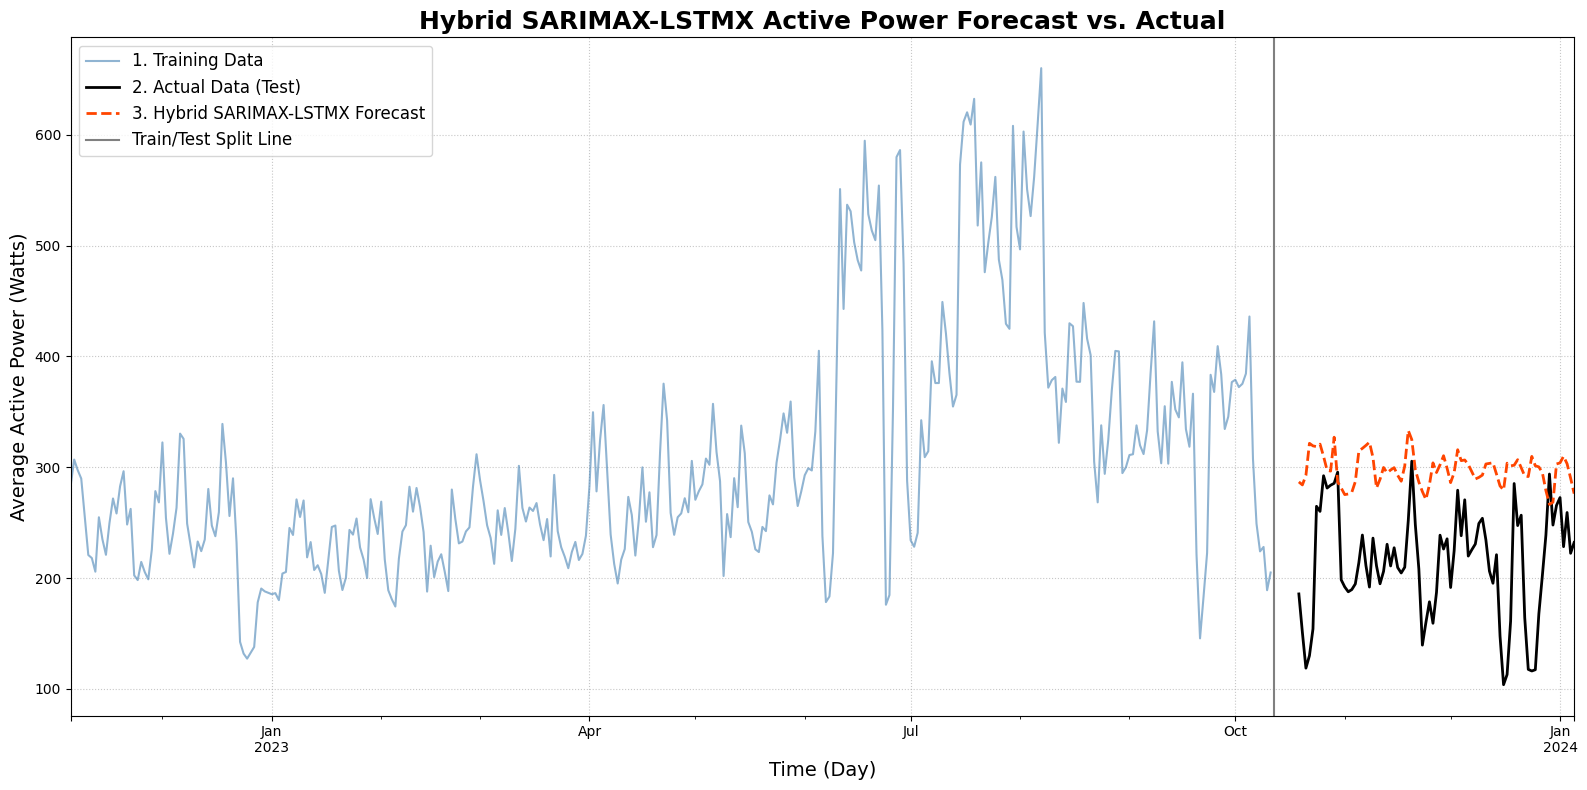

In [13]:
initial_res = scaled_lstm_train_input[-look_back:, :].copy()

# List to store Residuals predictions (N_t)
lstm_test_pred_res_list = []
current_input = initial_res.reshape(1, look_back, N_FEATURES)

# Length of the test set needed for prediction
# Must exclude the first look_back days because LSTMX needs them as input
test_length = len(test_data) - look_back

for i in range(test_length):
    # Predict the next step (Residual_t)
    next_residual_scaled = model_lstm.predict(current_input, verbose=0)

    # Store the scaled prediction
    lstm_test_pred_res_list.append(next_residual_scaled[0, 0])

    # Update input for the next step
    # New Input = [past window] + [predicted residual] + [actual exogenous]

    # 1. Predicted Residuals (first column only)
    new_residual_col = next_residual_scaled.reshape(1, 1)

    # 2. Actual Exogenous (at time i + look_back)
    # Fix: Create a temporary array with 3 features (dummy residual + actual exog) for scaling
    temp_exog_input_for_scaler = np.hstack([np.zeros((1, 1)), test_exog[look_back + i:look_back + i + 1]])
    scaled_actual_exog_cols = scaler.transform(temp_exog_input_for_scaler)[:, 1:] # Get only scaled temp and humidity

    # 3. Create new input vector (Resid_pred + Scaled_Exog_actual)
    new_step = np.hstack([new_residual_col, scaled_actual_exog_cols])

    # 4. Update the sliding window
    current_input = np.append(current_input[:, 1:, :], new_step.reshape(1, 1, N_FEATURES), axis=1)


# Inverse transform to unscale the Residuals prediction
# Must create a dummy array for Inverse Transform to work (column 0 is Residuals)
dummy_array = np.zeros((len(lstm_test_pred_res_list), N_FEATURES))
dummy_array[:, 0] = np.array(lstm_test_pred_res_list)
lstm_test_pred_res = scaler.inverse_transform(dummy_array)[:, 0]

# --- 4. HYBRID FORECAST AGGREGATION AND EVALUATION ---
# Alignment: Slice SARIMAX prediction (L_t) to match LSTMX time index (N_t)
sarimax_test_pred_aligned = sarimax_test_pred[look_back:]

# Hybrid Forecast: Sum(L_t_aligned + N_t)
hybrid_test_pred = sarimax_test_pred_aligned + lstm_test_pred_res

# Actual data for evaluation (must also be sliced)
actual_test_data_aligned = test_data[look_back:]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_test_data_aligned, hybrid_test_pred)
rmse = np.sqrt(mean_squared_error(actual_test_data_aligned, hybrid_test_pred))
r2 = r2_score(actual_test_data_aligned, hybrid_test_pred)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Adding a small epsilon or filtering out zero/near-zero values in y_true is recommended for production
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_test_data_aligned, hybrid_test_pred)

print("--- OPTIMIZED HYBRID SARIMAX-LSTMX RESULTS ---")
print(f'Optimized Hybrid MAE (SARIMAX-LSTMX): {mae:.3f}')
print(f'Optimized Hybrid RMSE (SARIMAX-LSTMX): {rmse:.3f}')
print(f'Optimized Hybrid R2 Score (SARIMAX-LSTMX): {r2:.3f}')
print(f'Optimized Hybrid MAPE (SARIMAX-LSTMX): {mape:.3f}%')


# --- 5. PLOTTING CODE ---
# 1. Prepare data for plotting
test_start_index = train_size + look_back
time_index = daily_df.index[test_start_index:]

# Create Series for actual and predicted data on the test set
actual_series = pd.Series(actual_test_data_aligned, index=time_index)
hybrid_prediction_series = pd.Series(hybrid_test_pred, index=time_index)
train_series = daily_df.iloc[:train_size][target_col]


# 2. Plot comparison chart
plt.figure(figsize=(16, 8))


# Training Data (Light Blue - represents historical data)
train_series.plot(label='1. Training Data', color='#4682B4', linewidth=1.5, alpha=0.6)

# Actual Data on Test Set (Black - standard for Actual)
actual_series.plot(label='2. Actual Data (Test)', color='black', linewidth=2)

# Optimized Hybrid Forecast (Red - for clear distinction)
hybrid_prediction_series.plot(label='3. Hybrid SARIMAX-LSTMX Forecast', color='#FF4500', linestyle='--', linewidth=2)

# Set Title and Labels
plt.title('Hybrid SARIMAX-LSTMX Active Power Forecast vs. Actual', fontsize=18, fontweight='bold')
plt.xlabel('Time (Day)', fontsize=14)
plt.ylabel('Average Active Power (Watts)', fontsize=14)

# Add vertical line separating Train and Test sets
plt.axvline(x=daily_df.index[train_size], color='gray', linestyle='-', linewidth=1.5, label='Train/Test Split Line')

# Display Legend
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()